In [ ]:
pip install xgboost scikit-learn deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 5.2 MB/s eta 0:00:00


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.3 MB/s eta 0:00:00


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.9 MB/s eta 0:00:00


In [ ]:
pip install imbalanced-learn

In [ ]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import re
from functools import partial
from scipy.stats import mode
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer, PowerTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from collections import Counter
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import optuna
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from deap import base, creator, tools, algorithms
import random
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from collections import Counter

In [ ]:
from google.colab import files
uploaded2 = files.upload()

Saving train-Cirrhosis Outcomes.csv to train-Cirrhosis Outcomes.csv


In [ ]:
from google.colab import files
uploaded2 = files.upload()

Saving test- Cirrhosis Outcomes.csv to test- Cirrhosis Outcomes.csv


In [ ]:
train = pd.read_csv('train-Cirrhosis Outcomes.csv')
test = pd.read_csv('test- Cirrhosis Outcomes.csv')

In [ ]:
# Check for duplicates
duplicate_rows = train[train.duplicated()]
print(f"Number of duplicate rows: {len(duplicate_rows)}")

duplicate_rows1 = test[test.duplicated()]
print(f"Number of duplicate rows: {len(duplicate_rows1)}")

Number of duplicate rows: 0
Number of duplicate rows: 0


In [ ]:
X = train.drop(columns=['Status'])
y = train['Status']

In [ ]:
X.head(2)

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,S,Y
0,0,999,D-penicillamine,21532,M,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,0,0
1,1,2574,Placebo,19237,F,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,0,0


In [ ]:
y.head(2)

,Status
0,D
1,C


In [ ]:
#X['Edema'] = X['Edema'].map({'N': 0, 'Y': 1, 'S': 1})
y = y.map({'C': 0, 'CL': 1, 'D': 2})
X = train.drop(columns = ['Edema', 'Status'], axis = 1)
X = pd.concat([X, pd.get_dummies(train['Edema'], drop_first = True, dtype = int)], axis = 1)
X['Drug'] = X['Drug'].map({'D-penicillamine': 0, 'Placebo': 1})
X['Sex'] = X['Sex'].map({'F': 0, 'M': 1})
X['Ascites'] = X['Ascites'].map({'N': 0, 'Y': 1})
X['Hepatomegaly'] = X['Hepatomegaly'].map({'N': 0, 'Y': 1})
X['Spiders'] = X['Spiders'].map({'N': 0, 'Y': 1})

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def evaluate_individual(individual):

    selected_features = [i for i, bit in enumerate(individual) if bit == 1]

    if len(selected_features) == 0:
        return 0,

    X_train_selected = X_train.iloc[:, selected_features]
    X_test_selected = X_test.iloc[:, selected_features]
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy,


In [ ]:
# Genetic Algorithm parameters
toolbox = base.Toolbox()
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, len(X_train.columns))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)


population_size = 50
num_generations = 20
crossover_prob = 0.7
mutation_prob = 0.2

population = toolbox.population(n=population_size)


for gen in range(num_generations):

    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < crossover_prob:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < mutation_prob:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    invalid_individuals = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_individuals)
    for ind, fit in zip(invalid_individuals, fitnesses):
        ind.fitness.values = fit
    population[:] = offspring

    fits = [ind.fitness.values[0] for ind in population]
    print(f"Generation {gen}: Best Accuracy = {max(fits):.4f}")


In [ ]:
best_individual = tools.selBest(population, k=1)[0]
selected_features = [i for i, bit in enumerate(best_individual) if bit == 1]
print("Selected features:", selected_features)
X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]

final_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
final_model.fit(X_train_selected, y_train)
final_predictions = final_model.predict(X_test_selected)

final_accuracy = accuracy_score(y_test, final_predictions)
print(f"Final model accuracy on selected features: {final_accuracy:.4f}")


Selected features: [1, 3, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18]
Final model accuracy on selected features: 0.8387


In [ ]:
feature_names = X_train.columns[selected_features]
print("Selected feature names:", feature_names.tolist())

Selected feature names: ['N_Days', 'Age', 'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']


In [ ]:
X.head(2)

,N_Days,Drug,Age,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,S,Y
0,999,0,21532,0,0,2.3,316.0,3.35,172.0,179.80,63.0,394.0,9.7,3.0,0,0
1,2574,1,19237,0,0,0.9,364.0,3.54,63.0,134.85,88.0,361.0,11.0,3.0,0,0


In [ ]:
X = X.drop('id', axis=1)
X = X.drop('Sex', axis=1)
X = X.drop('Ascites', axis=1)
X = X.drop('Alk_Phos', axis=1)

In [ ]:
X.shape

(7905, 16)

In [ ]:
print("Checking for NaN values in selected columns:")
print(X.isnull().sum())

Checking for NaN values in selected columns:
N_Days           0
Drug             0
Age              0
Hepatomegaly     0
Spiders          0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
S                0
Y                0
dtype: int64


In [ ]:
from sklearn.ensemble import IsolationForest
data_no_outliers = X.copy()
iso_forest = IsolationForest(contamination=0.05, random_state=42)

data_no_outliers['anomaly'] = iso_forest.fit_predict(data_no_outliers)

data_no_outliers = data_no_outliers[data_no_outliers['anomaly'] == 1]
data_no_outliers.drop(columns=['anomaly'], inplace=True)
print(f"Data shape after removing multivariate outliers: {data_no_outliers.shape}")


Data shape after removing multivariate outliers: (7509, 16)


In [ ]:
X_clean = data_no_outliers
y_clean = y[data_no_outliers.index]

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Define the degree of interaction you want (degree=2 will give pairwise interactions)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

# Transform the original feature set to include interaction terms
X_interaction = poly.fit_transform(X_clean)

# Get feature names (optional, for keeping track of new feature names)
feature_names = poly.get_feature_names_out(input_features=X_clean.columns)

# Convert to DataFrame for easier interpretation
X_interaction_df = pd.DataFrame(X_interaction, columns=feature_names)

# Optionally concatenate the interaction features with the original feature set
X_combined = pd.concat([X_clean.reset_index(drop=True), X_interaction_df], axis=1)

# View the new dataset with interaction terms
print(X_combined.head())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print('Original class distribution:', Counter(y_train))
print('SMOTE class distribution:', Counter(y_train_smote))

skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=42)

Original class distribution: Counter({0: 3942, 2: 1849, 1: 216})
SMOTE class distribution: Counter({0: 3942, 2: 3942, 1: 3942})


In [ ]:
%%time
logit_cv = cross_val_score(make_pipeline(PowerTransformer(), LogisticRegression(multi_class = 'ovr',
                                                                                max_iter = 1000)),
                           X_train_smote,
                           y_train_smote,
                           scoring = 'neg_log_loss',
                           cv = skf,
                           n_jobs = -1)

print(f"The 10-folds oof Log-Loss score is {-1*logit_cv.mean()}")

The 10-folds oof Log-Loss score is 0.7562103231657423
CPU times: user 62.1 ms, sys: 33.7 ms, total: 95.8 ms
Wall time: 1.72 s


In [ ]:
%%time
RF_cv = cross_val_score(RandomForestClassifier(**{'n_estimators': 1000,
                                                  'criterion': 'log_loss',
                                                  'max_depth': 14,
                                                  'min_samples_split': 3,
                                                  'min_samples_leaf': 1,
                                                  'max_features': 4,
                                                  'random_state': 1,
                                                  'n_jobs': -1}),
                        X_train_smote,
                        y_train_smote,
                        scoring = 'neg_log_loss',
                        cv = skf,
                        n_jobs = -1)

print(f"The 10-folds oof Log-Loss score of the RF is {-1*RF_cv.mean()}")

The 10-folds oof Log-Loss score of the RF is 0.36516947276480044
CPU times: user 1.44 s, sys: 269 ms, total: 1.71 s
Wall time: 4min 28s


In [ ]:
%%time
HB_cv = cross_val_score(HistGradientBoostingClassifier(**{'l2_regularization': 8.876168706639714,
                                                          'early_stopping': False,
                                                          'learning_rate': 0.009956485590638034,
                                                          'max_iter': 500,
                                                          'max_depth': 16,
                                                          'max_bins': 255,
                                                          'min_samples_leaf': 16,
                                                          'max_leaf_nodes': 18,
                                                          'random_state': 3}),
                        X_train_smote ,
                        y_train_smote,
                        scoring = 'neg_log_loss',
                        cv = skf,
                        n_jobs = -1)

print(f"The average 10-folds oof Log-Loss score of the HG is {-1*HB_cv.mean()}")


The average 10-folds oof Log-Loss score of the HG is 0.3977034967287164
CPU times: user 405 ms, sys: 83 ms, total: 488 ms
Wall time: 59.2 s


In [ ]:
%%time
LGBM_cv = cross_val_score(LGBMClassifier(**{'n_estimators': 1000,
                                            'learning_rate': 0.013657589160895923,
                                            'max_depth': 17,
                                            'reg_alpha': 1.9791969860931342,
                                            'reg_lambda': 1.2857088172765347,
                                            'num_leaves': 37,
                                            'subsample': 0.6351453342675659,
                                            'colsample_bytree': 0.2644509924064132}),
                          X_train_smote,
                          y_train_smote,
                          scoring = 'neg_log_loss',
                          cv = skf,
                          n_jobs = -1)

print(f"The average 10-folds oof Log-Loss score of the LGBM model is {-1*LGBM_cv.mean()}")

The average 10-folds oof Log-Loss score of the LGBM model is 0.3095953545769762
CPU times: user 379 ms, sys: 91.2 ms, total: 470 ms
Wall time: 56 s


In [ ]:
%%time
XGB_cv = cross_val_score(XGBClassifier(**{'max_depth': 7,
                                          'learning_rate': 0.03570188608151033,
                                          'n_estimators': 1000,
                                          'gamma': 0.6440001307764849,
                                          'min_child_weight': 2,
                                          'colsample_bytree': 0.27034458854562116,
                                          'subsample': 0.8435412915999765}),
                          X_train_smote,
                          y_train_smote,
                          scoring = 'neg_log_loss',
                          cv = skf,
                          n_jobs = -1)

print(f"The average 10-folds oof Log-Loss score of the XGBoost model is {-1*XGB_cv.mean()}")

The average 10-folds oof Log-Loss score of the XGBoost model is 0.30849004834386384
CPU times: user 274 ms, sys: 128 ms, total: 402 ms
Wall time: 36.6 s


In [ ]:
%%time
Cat_cv = cross_val_score(CatBoostClassifier(loss_function = 'MultiClass',
                                            iterations = 2000,
                                            learning_rate = 0.01,
                                            depth = 8,
                                            verbose = False,
                                            task_type = 'CPU'),
                          X_train_smote,
                          y_train_smote,
                          scoring = 'neg_log_loss',
                          cv = skf,
                          n_jobs = -1)

print(f"The average 10-folds oof Log-Loss score of the CatBoost model is {-1*Cat_cv.mean()}")


The average 10-folds oof Log-Loss score of the CatBoost model is 0.3501112453966212
CPU times: user 2.88 s, sys: 607 ms, total: 3.49 s
Wall time: 10min 7s


In [ ]:
%%time
ET_cv = cross_val_score(ExtraTreesClassifier(criterion = 'log_loss',
                                             n_estimators = 500,
                                             min_samples_leaf = 3,
                                             max_depth = 15,
                                             random_state = 2),
                        X_train_smote,
                        y_train_smote,
                        scoring = 'neg_log_loss',
                        cv = skf,
                        n_jobs = -1)

print(f"The 10-folds oof Log-Loss score of the ET is {-1*ET_cv.mean()}")

The 10-folds oof Log-Loss score of the ET is 0.5297411751209449
CPU times: user 239 ms, sys: 88.7 ms, total: 328 ms
Wall time: 35.9 s


In [ ]:
best_knn_params = {
    'n_neighbors': 61,
    'weights': 'uniform',
    'p': 1
}
knn = KNeighborsClassifier(**best_knn_params)

knn_cv = cross_val_score(
    knn,
    X_train_smote,
    y_train_smote,          # SMOTE-augmented training labels
    scoring='neg_log_loss',  # Use log-loss as the scoring metric
    cv=skf,                  # StratifiedKFold cross-validation
    n_jobs=-1                # Use all CPU cores
)
print(f"The average 10-fold OOF Log-Loss score of the KNN model is {-1 * knn_cv.mean():.4f}")

The average 10-fold OOF Log-Loss score of the KNN model is 0.7522


In [ ]:
%%time
base_estimator = DecisionTreeClassifier(
    max_depth=18,
    min_samples_split=3,
    min_samples_leaf=1,
    ccp_alpha=0.3381770775051377
)

# AdaBoost model using the base estimator and other tuned parameters
ada_model = AdaBoostClassifier(
    estimator=base_estimator,  # Include the base estimator
    n_estimators=166,
    learning_rate=2.176465442176842
)

# Cross-validation using 10-folds and OOF Log-Loss scoring
ada_cv = cross_val_score(ada_model,
                         X_train_smote,
                         y_train_smote,
                         scoring='neg_log_loss',
                         cv=skf,
                         n_jobs=-1)

# Print the average OOF Log-Loss score
print(f"The average 10-folds OOF Log-Loss score of the AdaBoost model is {-1 * ada_cv.mean():.6f}")


The average 10-folds OOF Log-Loss score of the AdaBoost model is 1.104050
CPU times: user 2.9 s, sys: 615 ms, total: 3.51 s
Wall time: 4min 55s


In [ ]:
model_performance = pd.DataFrame()
model_performance['Model'] = ['Logistic', 'RF', 'ET', 'Hist', 'LGBM', 'XGBoost', 'CatBoost']
model_performance['10-folds oof Log-Loss'] = [-1*logit_cv.mean(), -1*RF_cv.mean(), -1*ET_cv.mean(), -1*HB_cv.mean(), -1*LGBM_cv.mean(), -1*XGB_cv.mean(), -1*Cat_cv.mean()]
print(f"The followig table shows the performance of the considered models: \n\n{model_performance}")

The followig table shows the performance of the considered models: 

      Model  10-folds oof Log-Loss
0  Logistic               0.756210
1        RF               0.365169
2        ET               0.529741
3      Hist               0.397703
4      LGBM               0.309595
5   XGBoost               0.308490
6  CatBoost               0.350111


In [ ]:
md1 = make_pipeline(PowerTransformer(), LogisticRegression(multi_class = 'ovr',
                                                           max_iter = 1000))

md2 = RandomForestClassifier(**{'n_estimators': 1000,
                                'criterion': 'log_loss',
                                'max_depth': 14,
                                'min_samples_split': 3,
                                'min_samples_leaf': 1,
                                'max_features': 4,
                                'random_state': 1,
                                'n_jobs': -1})

md3 = ExtraTreesClassifier(criterion = 'log_loss',
                           n_estimators = 1000,
                           min_samples_leaf = 1,
                           max_depth = 15,
                           random_state = 2)

md4 = HistGradientBoostingClassifier(**{'l2_regularization': 8.876168706639714,
                                        'early_stopping': False,
                                        'learning_rate': 0.009956485590638034,
                                        'max_iter': 500,
                                        'max_depth': 16,
                                        'max_bins': 255,
                                        'min_samples_leaf': 16,
                                        'max_leaf_nodes': 18,
                                        'random_state': 3})

md5 = LGBMClassifier(**{'n_estimators': 1000,
                        'learning_rate': 0.013657589160895923,
                        'max_depth': 17,
                        'reg_alpha': 1.9791969860931342,
                        'reg_lambda': 1.2857088172765347,
                        'num_leaves': 37,
                        'subsample': 0.6351453342675659,
                        'colsample_bytree': 0.2644509924064132})

md6 = XGBClassifier(**{'max_depth': 7,
                       'learning_rate': 0.03570188608151033,
                       'n_estimators': 1000,
                       'gamma': 0.6440001307764849,
                       'min_child_weight': 2,
                       'colsample_bytree': 0.27034458854562116,
                       'subsample': 0.8435412915999765})

md7 = CatBoostClassifier(loss_function = 'MultiClass',
                         iterations = 2000,
                         learning_rate = 0.01,
                         depth = 8,
                         verbose = False,
                         task_type = 'CPU')

In [ ]:
m8= KNeighborsClassifier(
    make_pipeline(PowerTransformer(), knn),
    X_train_smote,
    y_train_smote,
    scoring='neg_log_loss',
    cv=skf,
    n_jobs=-1)

In [ ]:
md1_pred, md2_pred, md3_pred, md4_pred, md5_pred, md6_pred, md7_pred = list(), list(), list(), list(), list(), list(), list()
y_test_list = list()

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for i, (train_idx, test_idx) in enumerate(skf.split(X_clean, y_clean)):
    X_train, X_test = X_clean.iloc[train_idx], X_clean.iloc[test_idx]
    y_train, y_test = y_clean.iloc[train_idx], y_clean.iloc[test_idx]

    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    md1.fit(X_train_smote, y_train_smote)
    md1_pred.append(md1.predict_proba(X_test))

    md2.fit(X_train_smote, y_train_smote)
    md2_pred.append(md2.predict_proba(X_test))

    md3.fit(X_train_smote, y_train_smote)
    md3_pred.append(md3.predict_proba(X_test))

    md4.fit(X_train_smote, y_train_smote)
    md4_pred.append(md4.predict_proba(X_test))

    md5.fit(X_train_smote, y_train_smote)
    md5_pred.append(md5.predict_proba(X_test))

    md6.fit(X_train_smote, y_train_smote)
    md6_pred.append(md6.predict_proba(X_test))

    md7.fit(X_train_smote, y_train_smote)
    md7_pred.append(md7.predict_proba(X_test))

    y_test_list.append(y_test)

In [ ]:
md4_pred, md5_pred, md6_pred = list(), list(), list()
md1_pred, md2_pred, md3_pred, md7_pred = list(), list(), list(), list()
Y_test_list = list()

smote = SMOTE(random_state=42)

skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=42)

for train_idx, test_idx in skf.split(X_clean, y_clean):

    X_train, X_test = X_clean.iloc[train_idx], X_clean.iloc[test_idx]
    y_train, y_test = y_clean.iloc[train_idx], y_clean.iloc[test_idx]

    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    md4.fit(X_train_smote, y_train_smote)
    md5.fit(X_train_smote, y_train_smote)
    md6.fit(X_train_smote, y_train_smote)
    md1.fit(X_train_smote, y_train_smote)
    md2.fit(X_train_smote, y_train_smote)
    md3.fit(X_train_smote, y_train_smote)
    md7.fit(X_train_smote, y_train_smote)


    md4_pred.append(md4.predict_proba(X_test))
    md5_pred.append(md5.predict_proba(X_test))
    md6_pred.append(md6.predict_proba(X_test))
    md1_pred.append(md1.predict_proba(X_test))
    md2_pred.append(md2.predict_proba(X_test))
    md3_pred.append(md3.predict_proba(X_test))
    md7_pred.append(md7.predict_proba(X_test))

    Y_test_list.append(y_test)

md4_all_preds = np.concatenate([np.argmax(pred, axis=1) for pred in md4_pred], axis=0)
md5_all_preds = np.concatenate([np.argmax(pred, axis=1) for pred in md5_pred], axis=0)
md6_all_preds = np.concatenate([np.argmax(pred, axis=1) for pred in md6_pred], axis=0)
md1_all_preds = np.concatenate([np.argmax(pred, axis=1) for pred in md1_pred], axis=0)
md2_all_preds = np.concatenate([np.argmax(pred, axis=1) for pred in md2_pred], axis=0)
md3_all_preds = np.concatenate([np.argmax(pred, axis=1) for pred in md3_pred], axis=0)
md7_all_preds = np.concatenate([np.argmax(pred, axis=1) for pred in md7_pred], axis=0)

Y_test_all = np.concatenate(Y_test_list, axis=0)


In [ ]:
# Concatenate all true labels from all folds
Y_test_all = np.concatenate(y_test_list, axis=0)

# Calculate accuracy for each model
md4_accuracy = accuracy_score(Y_test_all, md4_all_preds)
md5_accuracy = accuracy_score(Y_test_all, md5_all_preds)
md6_accuracy = accuracy_score(Y_test_all, md6_all_preds)
md1_accuracy = accuracy_score(Y_test_all, md1_all_preds)
md2_accuracy = accuracy_score(Y_test_all, md2_all_preds)
md3_accuracy = accuracy_score(Y_test_all, md3_all_preds)
md7_accuracy = accuracy_score(Y_test_all, md7_all_preds)

# Print accuracies
print(f"md4 Accuracy: {md4_accuracy}")
print(f"md5 Accuracy: {md5_accuracy}")
print(f"md6 Accuracy: {md6_accuracy}")
print(f"md1 Accuracy: {md1_accuracy}")
print(f"md2 Accuracy: {md2_accuracy}")
print(f"md3 Accuracy: {md3_accuracy}")
print(f"md7 Accuracy: {md7_accuracy}")

md4 Accuracy: 0.8014382740711147
md5 Accuracy: 0.82074843521108
md6 Accuracy: 0.8224796910374218
md1 Accuracy: 0.7142096151285124
md2 Accuracy: 0.8019709681715275
md3 Accuracy: 0.7901185244373419
md7 Accuracy: 0.8043680916233853


In [ ]:
md4_pred.append(md4.predict_proba(X_test))
md5_pred.append(md5.predict_proba(X_test))
md6_pred.append(md6.predict_proba(X_test))
md1_pred.append(md1.predict_proba(X_test))
md2_pred.append(md2.predict_proba(X_test))
md3_pred.append(md3.predict_proba(X_test))
md7_pred.append(md7.predict_proba(X_test))

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score

md4_all_preds = np.concatenate([np.argmax(pred, axis=1) for pred in md4_pred], axis=0)
md5_all_preds = np.concatenate([np.argmax(pred, axis=1) for pred in md5_pred], axis=0)
md6_all_preds = np.concatenate([np.argmax(pred, axis=1) for pred in md6_pred], axis=0)
md1_all_preds = np.concatenate([np.argmax(pred, axis=1) for pred in md1_pred], axis=0)
md2_all_preds = np.concatenate([np.argmax(pred, axis=1) for pred in md2_pred], axis=0)
md3_all_preds = np.concatenate([np.argmax(pred, axis=1) for pred in md3_pred], axis=0)
md7_all_preds = np.concatenate([np.argmax(pred, axis=1) for pred in md7_pred], axis=0)

Y_test_all = np.concatenate(Y_test_list, axis=0)

def calculate_metrics(y_true, y_pred, model_name):
    f1 = f1_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')

    print(f"{model_name} F1-score: {f1}")
    print(f"{model_name} Recall: {recall}")
    print(f"{model_name} Precision: {precision}")
    print("")

calculate_metrics(Y_test_all, md4_all_preds, "md4")
calculate_metrics(Y_test_all, md5_all_preds, "md5")
calculate_metrics(Y_test_all, md6_all_preds, "md6")
calculate_metrics(Y_test_all, md1_all_preds, "md1")
calculate_metrics(Y_test_all, md2_all_preds, "md2")
calculate_metrics(Y_test_all, md3_all_preds, "md3")
calculate_metrics(Y_test_all, md7_all_preds, "md7")


md4 F1-score: 0.8033991481124323
md4 Recall: 0.8014382740711147
md4 Precision: 0.8059709244274316

md5 F1-score: 0.8156368764510278
md5 Recall: 0.82074843521108
md5 Precision: 0.8131485059620428

md6 F1-score: 0.8177975978148545
md6 Recall: 0.8224796910374218
md6 Precision: 0.8150838977915976

md1 F1-score: 0.7444067842402312
md1 Recall: 0.7142096151285124
md1 Precision: 0.7859248900116284

md2 F1-score: 0.8016596712177458
md2 Recall: 0.8019709681715275
md2 Precision: 0.8013542339853352

md3 F1-score: 0.7934214117050064
md3 Recall: 0.7901185244373419
md3 Precision: 0.7971497822722525

md7 F1-score: 0.8040544764513236
md7 Recall: 0.8043680916233853
md7 Precision: 0.8037575563434426



In [ ]:
from sklearn.metrics import log_loss

Y_test_all = np.concatenate(y_test_list, axis=0)
md1_all_probs = np.concatenate(md1_pred, axis=0)
md2_all_probs = np.concatenate(md2_pred, axis=0)
md3_all_probs = np.concatenate(md3_pred, axis=0)
md4_all_probs = np.concatenate(md4_pred, axis=0)
md5_all_probs = np.concatenate(md5_pred, axis=0)
md6_all_probs = np.concatenate(md6_pred, axis=0)
md7_all_probs = np.concatenate(md7_pred, axis=0)

md1_log_loss = log_loss(Y_test_all, md1_all_probs)
md2_log_loss = log_loss(Y_test_all, md2_all_probs)
md3_log_loss = log_loss(Y_test_all, md3_all_probs)
md4_log_loss = log_loss(Y_test_all, md4_all_probs)
md5_log_loss = log_loss(Y_test_all, md5_all_probs)
md6_log_loss = log_loss(Y_test_all, md6_all_probs)
md7_log_loss = log_loss(Y_test_all, md7_all_probs)

# Print log loss for each model
print(f"Log Loss for md1: {md1_log_loss:.6f}")
print(f"Log Loss for md2: {md2_log_loss:.6f}")
print(f"Log Loss for md3: {md3_log_loss:.6f}")
print(f"Log Loss for md4: {md4_log_loss:.6f}")
print(f"Log Loss for md5: {md5_log_loss:.6f}")
print(f"Log Loss for md6: {md6_log_loss:.6f}")
print(f"Log Loss for md7: {md7_log_loss:.6f}")


Log Loss for md1: 0.734406
Log Loss for md2: 0.519154
Log Loss for md3: 0.594114
Log Loss for md4: 0.512481
Log Loss for md5: 0.463641
Log Loss for md6: 0.466752
Log Loss for md7: 0.502974


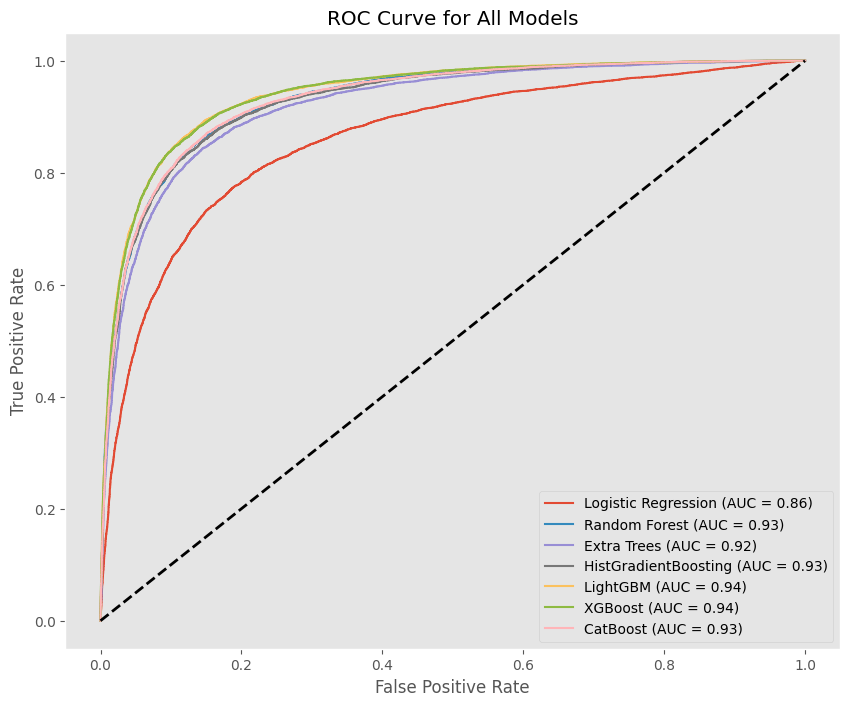

In [ ]:

n_classes = 3

Y_test_all = np.concatenate(Y_test_list, axis=0)
Y_test_binarized = label_binarize(Y_test_all, classes=[0, 1, 2])

models_probs = {
    'Logistic Regression': np.concatenate(md1_pred, axis=0),
    'Random Forest': np.concatenate(md2_pred, axis=0),
    'Extra Trees': np.concatenate(md3_pred, axis=0),
    'HistGradientBoosting': np.concatenate(md4_pred, axis=0),
    'LightGBM': np.concatenate(md5_pred, axis=0),
    'XGBoost': np.concatenate(md6_pred, axis=0),
    'CatBoost': np.concatenate(md7_pred, axis=0)
}


plt.figure(figsize=(10, 8))

for model_name, y_pred_proba in models_probs.items():

    assert y_pred_proba.shape[0] == Y_test_binarized.shape[0], f"Mismatch in samples for {model_name}"
    fpr, tpr, roc_auc = dict(), dict(), dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test_binarized[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_binarized.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.plot(fpr["micro"], tpr["micro"], label=f'{model_name} (AUC = {roc_auc["micro"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for All Models')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

# Generate and print classification reports for each model
print("Classification Report for Model 1 (md1):")
print(classification_report(Y_test_all, md1_all_preds))

print("Classification Report for Model 2 (md2):")
print(classification_report(Y_test_all, md2_all_preds))

print("Classification Report for Model 3 (md3):")
print(classification_report(Y_test_all, md3_all_preds))

print("Classification Report for Model 4 (md4):")
print(classification_report(Y_test_all, md4_all_preds))

print("Classification Report for Model 5 (md5):")
print(classification_report(Y_test_all, md5_all_preds))

print("Classification Report for Model 6 (md6):")
print(classification_report(Y_test_all, md6_all_preds))

print("Classification Report for Model 7 (md7):")
print(classification_report(Y_test_all, md7_all_preds))


Classification Report for Model 1 (md1):
              precision    recall  f1-score   support

           0       0.87      0.77      0.81      4928
           1       0.11      0.43      0.18       270
           2       0.69      0.63      0.66      2311

    accuracy                           0.71      7509
   macro avg       0.56      0.61      0.55      7509
weighted avg       0.79      0.71      0.74      7509

Classification Report for Model 2 (md2):
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      4928
           1       0.31      0.30      0.30       270
           2       0.72      0.72      0.72      2311

    accuracy                           0.80      7509
   macro avg       0.63      0.63      0.63      7509
weighted avg       0.80      0.80      0.80      7509

Classification Report for Model 3 (md3):
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      4928
      

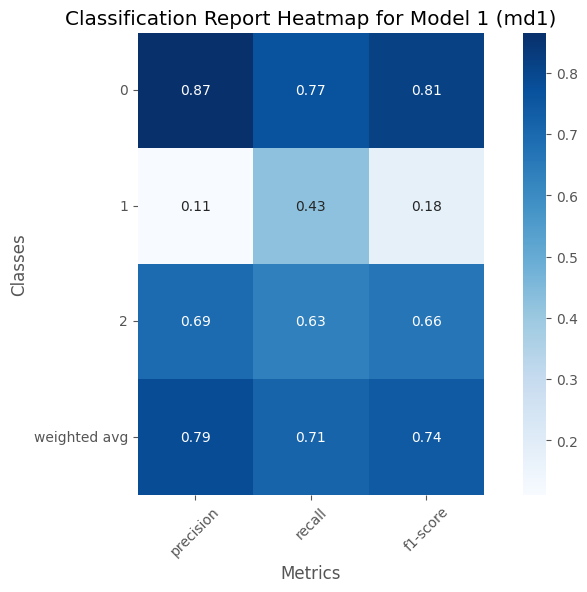

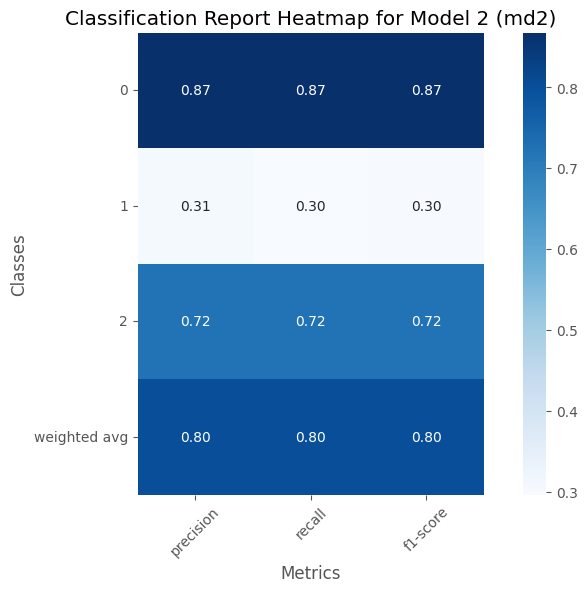

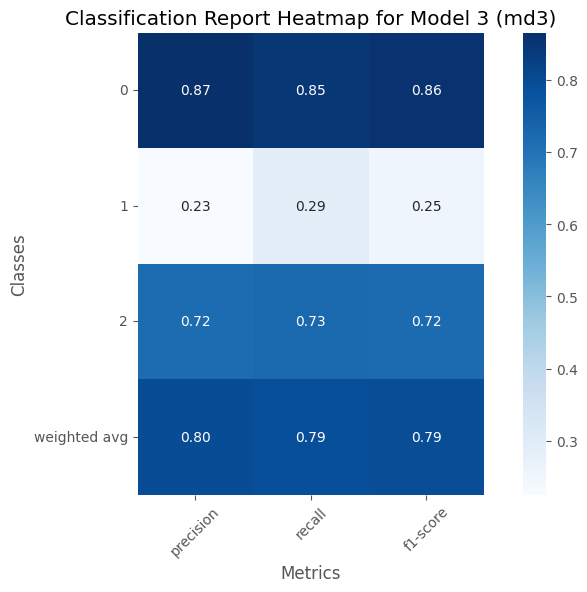

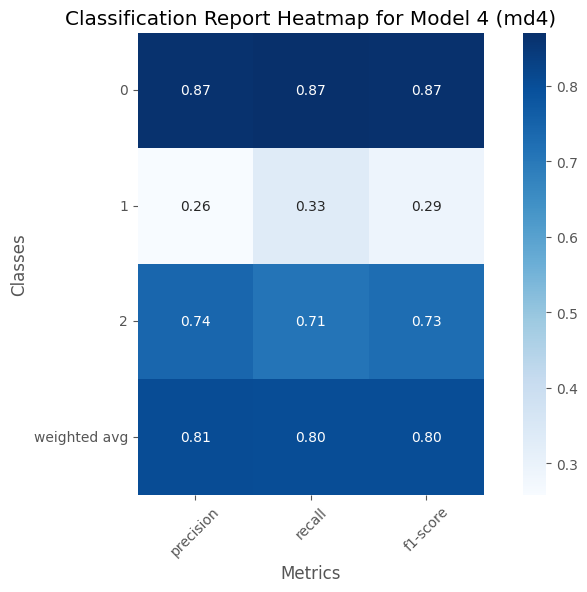

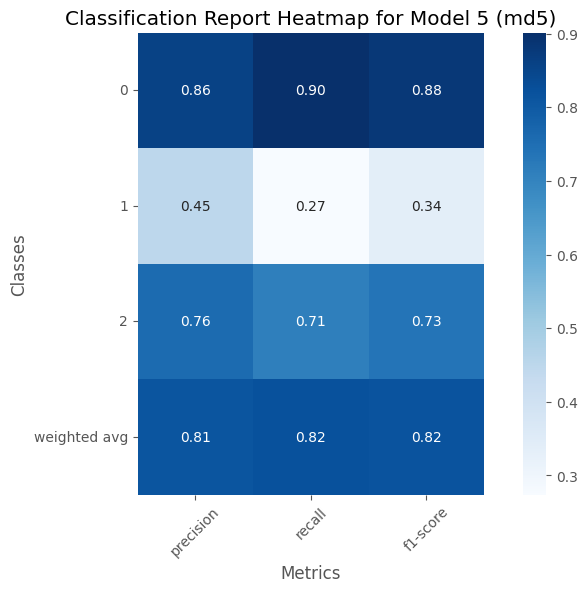

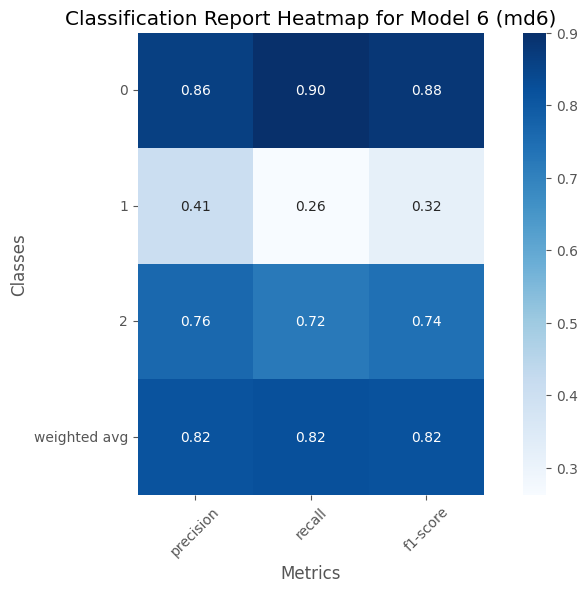

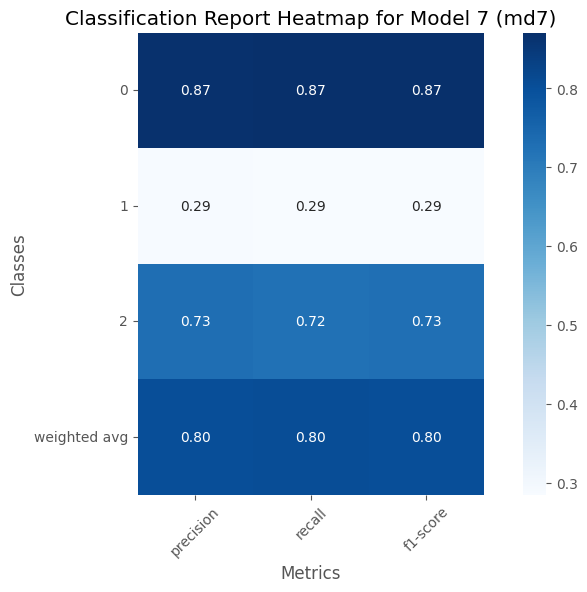

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

def visualize_classification_report(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()

    # Filter out the rows for accuracy and macro avg
    df_report = df_report.drop(index=['accuracy', 'macro avg'])

    plt.figure(figsize=(10, 6))
    sns.heatmap(df_report.iloc[:, :-1], annot=True, cmap='Blues', fmt='.2f', cbar=True, square=True)
    plt.title(f'Classification Report Heatmap for {model_name}')
    plt.xlabel('Metrics')
    plt.ylabel('Classes')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

# Generate and visualize classification reports for each model
visualize_classification_report(Y_test_all, md1_all_preds, "Model 1 (md1)")
visualize_classification_report(Y_test_all, md2_all_preds, "Model 2 (md2)")
visualize_classification_report(Y_test_all, md3_all_preds, "Model 3 (md3)")
visualize_classification_report(Y_test_all, md4_all_preds, "Model 4 (md4)")
visualize_classification_report(Y_test_all, md5_all_preds, "Model 5 (md5)")
visualize_classification_report(Y_test_all, md6_all_preds, "Model 6 (md6)")
visualize_classification_report(Y_test_all, md7_all_preds, "Model 7 (md7)")


In [ ]:
from sklearn.metrics import matthews_corrcoef

# Assuming md1_all_preds, md2_all_preds, etc. contain the predicted class labels for each model
md1_mcc = matthews_corrcoef(Y_test_all, md1_all_preds)
md2_mcc = matthews_corrcoef(Y_test_all, md2_all_preds)
md3_mcc = matthews_corrcoef(Y_test_all, md3_all_preds)
md4_mcc = matthews_corrcoef(Y_test_all, md4_all_preds)
md5_mcc = matthews_corrcoef(Y_test_all, md5_all_preds)
md6_mcc = matthews_corrcoef(Y_test_all, md6_all_preds)
md7_mcc = matthews_corrcoef(Y_test_all, md7_all_preds)

# Print MCC for each model
print(f"MCC for Model 1 (md1): {md1_mcc:.4f}")
print(f"MCC for Model 2 (md2): {md2_mcc:.4f}")
print(f"MCC for Model 3 (md3): {md3_mcc:.4f}")
print(f"MCC for Model 4 (md4): {md4_mcc:.4f}")
print(f"MCC for Model 5 (md5): {md5_mcc:.4f}")
print(f"MCC for Model 6 (md6): {md6_mcc:.4f}")
print(f"MCC for Model 7 (md7): {md7_mcc:.4f}")


MCC for Model 1 (md1): 0.4664
MCC for Model 2 (md2): 0.5810
MCC for Model 3 (md3): 0.5638
MCC for Model 4 (md4): 0.5819
MCC for Model 5 (md5): 0.6102
MCC for Model 6 (md6): 0.6150
MCC for Model 7 (md7): 0.5856


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

# Initialize your models
md1 = ...
md2 = ...
md3 = ...
md4 = ...
md5 = ...
md6 = ...
md7 = ...

# Initialize the lists to hold the predictions and true labels for each fold
md1_pred, md2_pred, md3_pred, md4_pred, md5_pred, md6_pred, md7_pred = [], [], [], [], [], [], []
y_test_list = []

# Create a stratified K-Fold object
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform stratified K-fold cross-validation
for i, (train_idx, test_idx) in enumerate(skf.split(X_clean, y_clean)):
    X_train, X_test = X_clean.iloc[train_idx], X_clean.iloc[test_idx]
    y_train, y_test = y_clean.iloc[train_idx], y_clean.iloc[test_idx]

    # Apply SMOTE to the training set
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Train and predict with each model
    md1.fit(X_train_smote, y_train_smote)
    md1_pred.append(md1.predict_proba(X_test))

    md2.fit(X_train_smote, y_train_smote)
    md2_pred.append(md2.predict_proba(X_test))

    md3.fit(X_train_smote, y_train_smote)
    md3_pred.append(md3.predict_proba(X_test))

    md4.fit(X_train_smote, y_train_smote)
    md4_pred.append(md4.predict_proba(X_test))

    md5.fit(X_train_smote, y_train_smote)
    md5_pred.append(md5.predict_proba(X_test))

    md6.fit(X_train_smote, y_train_smote)
    md6_pred.append(md6.predict_proba(X_test))

    md7.fit(X_train_smote, y_train_smote)
    md7_pred.append(md7.predict_proba(X_test))

    # Append the true test labels for evaluation
    y_test_list.append(y_test)

# Concatenate predictions from all folds
md1_all_preds = np.concatenate([np.argmax(pred, axis=1) for pred in md1_pred], axis=0)
md2_all_preds = np.concatenate([np.argmax(pred, axis=1) for pred in md2_pred], axis=0)
md3_all_preds = np.concatenate([np.argmax(pred, axis=1) for pred in md3_pred], axis=0)
md4_all_preds = np.concatenate([np.argmax(pred, axis=1) for pred in md4_pred], axis=0)
md5_all_preds = np.concatenate([np.argmax(pred, axis=1) for pred in md5_pred], axis=0)
md6_all_preds = np.concatenate([np.argmax(pred, axis=1) for pred in md6_pred], axis=0)
md7_all_preds = np.concatenate([np.argmax(pred, axis=1) for pred in md7_pred], axis=0)

# Concatenate all true labels from all folds
y_test_all = np.concatenate(y_test_list, axis=0)

# Calculate accuracy for each model
md1_accuracy = accuracy_score(y_test_all, md1_all_preds)
md2_accuracy = accuracy_score(y_test_all, md2_all_preds)
md3_accuracy = accuracy_score(y_test_all, md3_all_preds)
md4_accuracy = accuracy_score(y_test_all, md4_all_preds)
md5_accuracy = accuracy_score(y_test_all, md5_all_preds)
md6_accuracy = accuracy_score(y_test_all, md6_all_preds)
md7_accuracy = accuracy_score(y_test_all, md7_all_preds)

# Print accuracies
print(f"md1 Accuracy: {md1_accuracy}")
print(f"md2 Accuracy: {md2_accuracy}")
print(f"md3 Accuracy: {md3_accuracy}")
print(f"md4 Accuracy: {md4_accuracy}")
print(f"md5 Accuracy: {md5_accuracy}")
print(f"md6 Accuracy: {md6_accuracy}")
print(f"md7 Accuracy: {md7_accuracy}")
